# Introducción:
En este proyecto, se aborda desafío de clasificar la viabilidad de un usuario utilizando datos relacionados con diferentes variables. El objetivo es construir un modelo predictivo que pueda determinar si un usuario es viable o no, lo cual es de gran relevancia en el contexto de este proyecto. Se ha realizado una serie de pasos previos, como limpieza de datos, análisis exploratorio y preparación de los datos, así como la selección y entrenamiento de diferentes modelos utilizando técnicas de validación cruzada y ajuste de hiperparámetros.

Tabla de contenidos:

1) Comprensión del negocio

2) Comprensión de los datos

3) Preparación de los datos

4) Modelado

5) Evaluación

6) Despliegue



# 1) Comprensión del negocio

El objetivo de este proyecto es evaluar la viabilidad de los clientes y determinar si son aptos para convertirse en clientes de la empresa. Para lograr esto, se ha desarrollado un modelo de clasificación basado en machine learning. El modelo utiliza datos de los clientes, como características demográficas, información de ocupación y datos financieros, para predecir si un cliente es viable o no.

La viabilidad de los clientes es un factor clave para el éxito y la rentabilidad de la empresa. Al identificar y enfocarse en clientes viables, la empresa puede optimizar sus recursos y esfuerzos, brindando servicios personalizados y aumentando la satisfacción del cliente. Además, al predecir con precisión la viabilidad de los clientes, la empresa puede minimizar el riesgo de pérdidas económicas y maximizar sus oportunidades de crecimiento.

Para evaluar la eficacia del modelo, se utilizará la métrica F1-score, que proporciona una medida equilibrada entre la precisión y el recall del modelo. Un puntaje alto de F1-score indica que el modelo puede identificar de manera efectiva a los clientes viables y no viables.

Una vez que se haya evaluado y validado el modelo, se exportará para su implementación en una API. Esto permitirá a la empresa utilizar el modelo de forma eficiente y automatizada, integrándolo en sus sistemas y aplicaciones existentes. La API permitirá clasificar rápidamente a los nuevos clientes y tomar decisiones comerciales basadas en la viabilidad predicha por el modelo.

## 2. Comprensión de los datos
<a id="gather"></a>
En la etapa de Comprensión de los datos, se nos ha proporcionado un conjunto de datos que contiene información relevante para evaluar la viabilidad de los clientes. Estos datos incluyen variables como edad, género, ingresos, deudas familiares y detalles de empleo, entre otros.

El objetivo es explorar y comprender en profundidad la naturaleza de los datos, identificar posibles patrones, relaciones y tendencias que puedan influir en la viabilidad de los clientes. También es importante examinar la calidad de los datos, identificar y abordar los valores faltantes, anomalías o inconsistencias que puedan afectar los resultados del modelo.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.core.interactiveshell import InteractiveShell
from utils.model_io  import dump_pickle

warnings.filterwarnings('ignore')


In [2]:
habi_df = pd.read_excel('./data/raw/dataset.xlsx')
habi_df.drop_duplicates(subset=['id'], inplace=True)


In [3]:
habi_df.head()

,id,birth_date,terms_conditions,gender,meta,date_exp_token,id.1,contact_id,type_occupation_id,type_independent_activity_id,...,company_phone,company_city_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
2,23963,1984-07-08,0,NaN,NaN,2023-01-16 18:16:50.0,4547,23963,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,23965,1985-02-14,0,NaN,NaN,NaN,4549,23965,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,24370,1997-01-09,0,NaN,NaN,NaN,4860,24370,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
5,24372,1997-01-09,1,NaN,NaN,2023-01-23 16:34:06.0,4862,24372,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


In [4]:
print(habi_df.shape)
print(habi_df.columns)

(2262, 33)
Index(['id', 'birth_date', 'terms_conditions', 'gender', 'meta',
       'date_exp_token', 'id.1', 'contact_id', 'type_occupation_id',
       'type_independent_activity_id', 'type_profession_id',
       'type_contract_id', 'init_occupation_date', 'incomes', 'extra_incomes',
       'familiar_debts', 'is_tax_return', 'loan_required', 'defer_years',
       'region_id', 'company_nit', 'company_name', 'company_address',
       'company_phone', 'company_city_id', 'name', 'label', 'is_active',
       'activity_code', 'name.1', 'label.1', 'viability', 'is_selected'],
      dtype='object')


### Data Content

Nota: Las siguientes definiciones son una descripción preliminar de los datos basada en la información proporcionada en el dataset. Es importante tener en cuenta que estas definiciones pueden requerir validación adicional con los stakeholders relevantes para obtener una comprensión más precisa. Sin embargo, sirven como punto de partida significativo para el análisis posterior.


**id:** ID del usuario

**birth_date:** Fecha de nacimiento del usuario

**terms_conditions:** Indica si el usuario aceptó los términos y condiciones

**gender:** Género del usuario

**meta:** Metadatos asociados a una transacción

**date_exp_token:** Fecha de expiración del token

**id.1**: ID de la ocupación del usuario

**contact_id:** ID del usuario - duplicado con "id

**type_occupation_id:** Tipo de ocupación del usuario

**type_independent_activity_id:** ID del tipo de actividad independiente

**type_profession_id:** ID del tipo de profesión

**type_contract_id:** ID del tipo de contrato

**init_occupation_date:** Fecha de inicio de la ocupación

**incomes:** Ingresos totales

**extra_incomes:** Ingresos extra

**familiar_debts:** Deudas relacionadas con la familia del usuario

**is_tax_return:** Indica si corresponde una declaración de impuestos

**loan_required:** Indica si se requiere un préstamo

**defer_years:** Número de años para los cuales se pospone el préstamo

**region_id:** ID de la región

**company_name:** Nombre de la empresa

**company_nit:** NIT (Número de Identificación Tributaria) 

**company_address:** Dirección de la empresa

**company_phone:** Número de teléfono de la empresa

**company_city_id:** ID de la ciudad donde se encuentra la empresa

**name:** nombre del reporte en ingles

**label:** nombre del reporte en español (duplicado con name)

**is_active:** Indica si el usuario está activo

**activity_code:** Código relacionado con una actividad específica

**name.1** : tipo de trabajo del usuario en ingles

**label.1** :tipo de trabajo del usuario en español (duplicado con name.1)

**viability:** Si el usuario es viable o no

**is_selected:** Si el usuario es seleccionado o no


In [5]:
habi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2262 entries, 0 to 3943
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            2262 non-null   int64  
 1   birth_date                    2233 non-null   object 
 2   terms_conditions              2262 non-null   int64  
 3   gender                        1 non-null      object 
 4   meta                          9 non-null      object 
 5   date_exp_token                1115 non-null   object 
 6   id.1                          2262 non-null   int64  
 7   contact_id                    2262 non-null   int64  
 8   type_occupation_id            2262 non-null   int64  
 9   type_independent_activity_id  2262 non-null   int64  
 10  type_profession_id            1 non-null      float64
 11  type_contract_id              0 non-null      float64
 12  init_occupation_date          1 non-null      object 
 13  incomes 

### Distribucion de nuestra variable objetivo

Nota: La variable objetivo en nuestro dataset presenta un desequilibrio. Observamos que hay aproximadamente el doble de registros en la clase 1 en comparación con la clase 0. Para abordar esta situación, aplicaremos dos enfoques:

`Undersampling`: Aplicaremos técnicas de subsampling para equilibrar las clases, reduciendo aleatoriamente la cantidad de muestras en la clase mayoritaria.

`Métrica resistente al desbalance de clases`: Utilizaremos una métrica de evaluación que sea robusta frente al desequilibrio de clases, lo cual nos permitirá tener una medida más precisa del rendimiento de nuestro modelo.

<Axes: xlabel='is_selected', ylabel='count'>

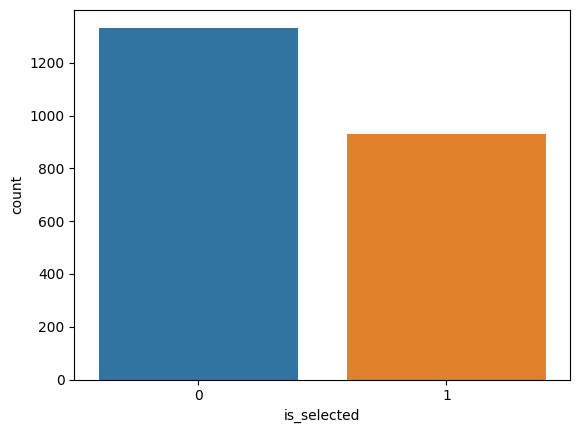

In [7]:
sns.countplot(x=habi_df['is_selected'])

### Examinando valores nulos 

`Nota`: Al examinar el mapa de calor de los valores nulos en nuestro dataset, podemos observar algunos detalles importantes:

* Hay varias columnas que están completamente llenas de valores nulos. Estas columnas deben ser eliminadas, ya que no aportarán ninguna información útil para nuestro ejercicio.

* También encontramos columnas que contienen valores nulos de forma parcial. En los pasos posteriores, mostraremos cómo manejar estas columnas y cómo estos valores nulos pueden proporcionar información relevante para nuestro análisis.

* Además, identificamos columnas que están completamente llenas de datos iguales, pero que no serán útiles para nuestro ejercicio. También hay columnas con valores repetidos en comparación con otras columnas, las cuales podemos descartar para simplificar nuestro análisis.



<Axes: >

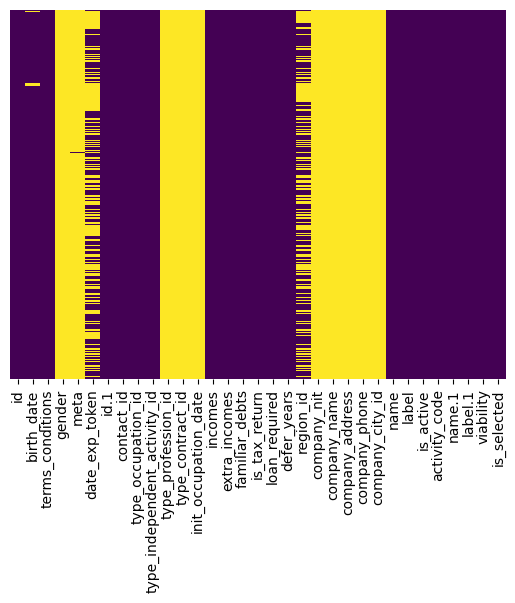

In [119]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

* 1) Columnas completamente nulas:

`gender`,`meta`,`type_profession_id`,`type_contract_id`,`init_occupation_date`,`company_nit`,`company_name`,`company_address`,`company_phone`,`company_city_id`

Estas columnas están completamente llenas de valores nulos y no aportan información útil para nuestro análisis. Por lo tanto, procederemos a eliminar estas columnas en etapas posteriores de nuestro proceso de preparación de datos.

* 2. Columnas parcialmente vacias

`date_exp_token`:Los campos de fecha en esta columna muestran un patrón similar a las fechas circundantes en el dataset. Podemos utilizar esta información para llenar los valores nulos utilizando fechas cercanas. Además, podemos crear una nueva variable llamada has_date_exp_token para indicar si esta columna originalmente tenía un valor nulo o no. Esto nos permitirá tener un registro de la ausencia de datos en esta columna.

In [8]:
habi_df[['date_exp_token']].head(10)

,date_exp_token
0,2022-11-25 23:13:29.0
2,2023-01-16 18:16:50.0
3,NaN
4,NaN
5,2023-01-23 16:34:06.0
6,2023-03-08 16:25:17.0
9,2023-04-05 17:05:16.0
12,NaN
13,NaN
14,NaN


`region_id`: Hay más de 1000 registros con valores nulos en esta columna, y algunas categorías se repiten con muy poca frecuencia. Para abordar este caso, podemos reemplazar los valores nulos por 0 y los valores que sean muy poco comunes por -1. Además, podemos crear una nueva columna llamada has_region_id para indicar si había o no un valor nulo en la columna original. Esto nos permitirá tener un registro de la presencia o ausencia de datos en esta columna.

<Axes: xlabel='region_id'>

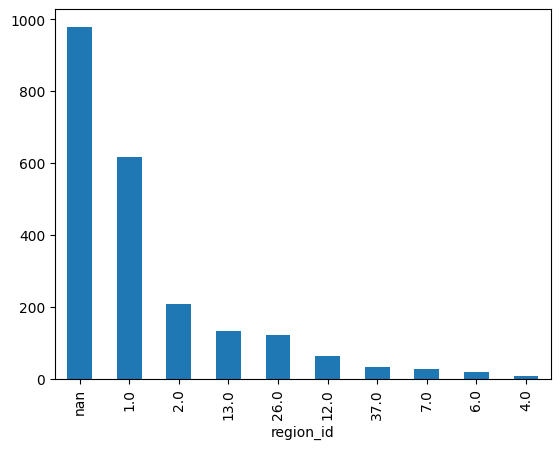

In [9]:
habi_df['region_id'].value_counts(dropna=False).head(10).plot.bar()

* 3.a  Las siguientes columnas están repetidas, pero codificadas con nombres diferentes. Debemos eliminarlas ya que proporcionarían información redundante para nuestro modelo:

- name (repetida con label)
- name.1 (repetida con ','label.1','activity_code','type_occupation_id)
- id (repetida con id.1)

In [122]:
habi_df[['name','label']].groupby(['name','label']).size()

name                                               label                                             
agriculture, livestock, hunting, forestry fishing  Agricultura, Ganadería, Caza, Silvicultura y Pesca     37
association and repair activities                  Actividades de Asociación y Reparación                 26
manufacture                                        Industrias Manufactureras                              70
other personal services activities                 Otras Actividades de Servicios Personales             309
others                                             Otros                                                 744
professional scientif and technical activities     Actividades Profesionales, Ciéntificas y Técnicas     439
real state activitys                               Actividades Inmobiliarias                             107
transport and storage                              Transporte y Almacenamiento                           100
wholesale and retail, auto

In [123]:
habi_df[['name.1','label.1','activity_code','type_occupation_id']].groupby(['name.1','label.1','activity_code','type_occupation_id']).size() 

name.1       label.1        activity_code  type_occupation_id
employee     Asalariado     3              1                       66
independent  Independiente  4              3                     2195
retired      Pensionado     8              2                        1
dtype: int64

In [124]:
habi_df[['id','id.1']].groupby(['id','id.1']).size() 

id     id.1 
520    7296     1
982    2118     1
1587   5220     1
1767   5        1
1842   37       1
               ..
31768  10530    1
31774  10532    1
31778  10536    1
31783  10541    1
31784  10542    1
Length: 2262, dtype: int64

* 3.b Eliminación de columnas redundantes e irrelevantes

La columna id.1 proporciona un identificador específico para cada usuario, pero no ofrece información útil para nuestro análisis y modelado. Esta columna tiene un valor único para la mayoría de los registros y no nos permite generalizar o extraer patrones relevantes. Por lo tanto, podemos eliminar esta columna ya que no aporta valor significativo a nuestro ejercicio.

<Axes: title={'center': 'Volumen de transacciones por usuario'}, xlabel='count'>

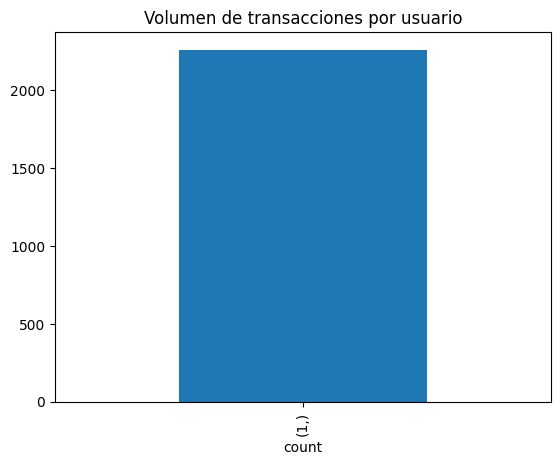

In [125]:
habi_df['id.1'].value_counts().to_frame().value_counts().plot.bar(title='Volumen de transacciones por usuario',)

* Columnas con datos unicos

Las siguientes columnas contienen un único valor en todo el conjunto de datos, lo que significa que no aportan ninguna información útil para nuestra clasificación. Por lo tanto, se eliminarán estas columnas, ya que solo introducirían ruido en nuestro modelo.

Text(0.5, 1.0, 'Distribution is_active')

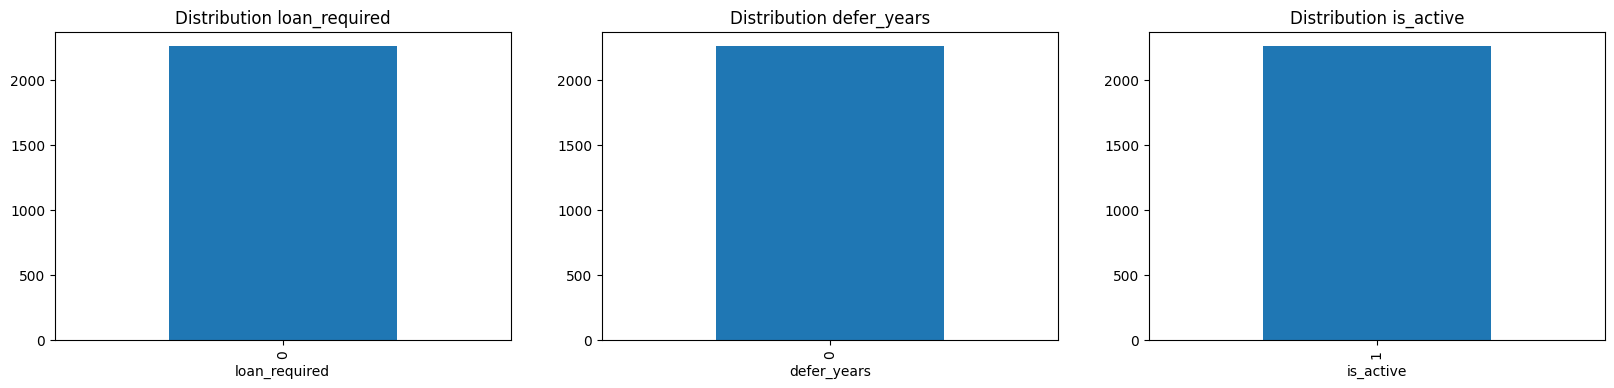

In [126]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
habi_df['loan_required'].value_counts().plot.bar(ax=axes[0] )
axes[0].set_title('Distribution loan_required')

habi_df['defer_years'].value_counts().plot.bar(ax=axes[1])
axes[1].set_title('Distribution defer_years')


habi_df['is_active'].value_counts().plot.bar(ax=axes[2])
axes[2].set_title('Distribution is_active')


## 3. Preparación de los datos

### Seleccion de la data

En la etapa de preparación de los datos, vamos a realizar la selección de columnas que serán utilizadas para el análisis y modelado. Para ello, identificaremos y eliminaremos tres tipos de columnas que no aportan información relevante:

`Columnas completamente nulas`: Estas columnas no contienen ningún valor en ninguna de las filas y, por lo tanto, no aportan ninguna información útil para nuestro análisis. Al eliminar estas columnas, reduciremos el ruido en nuestros datos y mejoraremos la eficiencia de nuestro modelo.

`Columnas con un único dato`: Estas columnas contienen el mismo valor en todas las filas del conjunto de datos. Al no haber variabilidad en estos datos, no aportan poder predictivo y no contribuyen a la capacidad de discriminación de nuestro modelo. Por lo tanto, eliminaremos estas columnas para simplificar nuestro conjunto de datos.

`Columnas de IDs de los registros`: Estas columnas contienen identificadores únicos para cada registro, como el ID del usuario o el ID de la ocupación. Sin embargo, estos identificadores son específicos de cada registro y no aportan información relevante para la clasificación de viabilidad. Por lo tanto, eliminaremos estas columnas para evitar introducir ruido y mejorar la interpretabilidad de nuestro modelo.

In [10]:
ids_columns = ['id','id.1','contact_id']
useless_columns = ['loan_required','defer_years','is_active']
null_columns = ["gender",
    "meta",
    "type_profession_id",
    "type_contract_id",
    "init_occupation_date",
    "company_nit",
    "company_name",
    "company_address",
    "company_phone",
    "company_city_id"
    ]
repeated_columns = ['label','label.1','label.1','activity_code','type_occupation_id']
drop_columns = ids_columns+useless_columns+null_columns+repeated_columns
habi_df = habi_df.drop(columns=drop_columns)

# Data Formatting
* ajustar nombres
* ajustar tipos

In [11]:
habi_df.dtypes

birth_date                       object
terms_conditions                  int64
date_exp_token                   object
type_independent_activity_id      int64
incomes                           int64
extra_incomes                     int64
familiar_debts                    int64
is_tax_return                     int64
region_id                       float64
name                             object
name.1                           object
viability                         int64
is_selected                       int64
dtype: object

In [12]:
habi_df.terms_conditions = habi_df.terms_conditions.astype(bool)
habi_df.type_independent_activity_id = habi_df.type_independent_activity_id.astype(str)
habi_df.name = habi_df.name.astype(str)
habi_df['name.1'] = habi_df['name.1'].astype(str)


In [13]:
habi_df = habi_df.rename(columns={'name':'activity','name.1':'job_role'})

In [131]:
habi_df.to_parquet('./data/prepared/habi_data_selection.parquet',index=None)

In [132]:
habi_df = pd.read_parquet('./data/prepared/habi_data_selection.parquet')

# Data Cleaning

### Limpieza de datos


Durante la etapa de limpieza de datos, nos hemos encontrado con la presencia de valores nulos en algunas columnas. Es importante tener en cuenta que la información nula también puede proporcionar pistas y patrones importantes en nuestro conjunto de datos. Por lo tanto, hemos tomado las siguientes medidas para manejar los datos nulos:

`birth_date`: Dado que el número de valores nulos es pequeño, hemos optado por eliminar los registros que contienen valores nulos en esta columna.

`date_exp_token`: Hemos observado que los datos faltantes en esta columna siguen un orden cronológico. Por lo tanto, hemos decidido completar los valores nulos utilizando los datos disponibles en un orden secuencial.

`region_id`: Ante la presencia de varios datos faltantes en esta columna, hemos optado por llenar los valores nulos con 0, creando así una nueva categoría que sirve como indicador de datos nulos.

Además, hemos creado dos nuevas características para capturar la presencia de datos nulos como patrones adicionales:

`has_expiration_date`: Esta característica indica si un registro tiene un valor nulo en la columna date_exp_token o no, permitiendo al modelo reconocer la ausencia de una fecha de expiración como un patrón adicional.

`has_region_id`: Similarmente, esta característica identifica si un registro tiene un valor nulo en la columna region_id o no, brindando al modelo información sobre la falta de información de la región del usuario.

In [14]:
# Crear mascara de de valores nulos
habi_df['has_region_id'] = ~habi_df.region_id.isnull()
habi_df['has_date_exp_token'] = ~habi_df.date_exp_token.isnull()

In [15]:

# eliminar registros con birth_date nulos
habi_df['birth_date'] = pd.to_datetime(habi_df['birth_date'],format='mixed',errors='coerce')
habi_df = habi_df[~habi_df.birth_date.isnull()]
habi_df['birth_date'] = habi_df['birth_date'].fillna(habi_df['birth_date'].median())

# Identificar valores nulos en region_id en una nueva columna y completar valores nulos con 0
habi_df['region_id'] = habi_df['region_id'].fillna(0).astype(int).astype(str)

# Remplazar nulos con valores cercanos
habi_df['date_exp_token'] = habi_df['date_exp_token'].fillna(method='ffill')

In [135]:
habi_df.shape

(2229, 15)

### Validacion de datos
Con el proceso anterior, nos damos cuenta que ya no tenemos valores nulos en nuestro dataset y ademas creamos 2 features nuevas para identificar si habian o no nulos 


<Axes: >

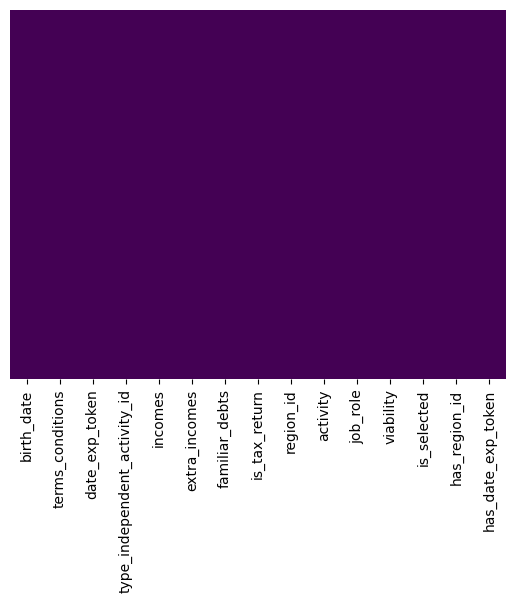

In [16]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Transformar valores de tiempo

In [17]:
habi_df['year_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.year
habi_df['month_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.month
habi_df['day_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.day

habi_df['year_birth'] = pd.to_datetime(habi_df['birth_date']).dt.year
habi_df['month_birth'] = pd.to_datetime(habi_df['birth_date']).dt.month
habi_df['day_birth'] = pd.to_datetime(habi_df['birth_date']).dt.day

habi_df = habi_df.drop(columns=['birth_date','date_exp_token'])

### Feature Engineering

Al analizar las distribuciones de las variables incomes, extra_incomes y familiar_debts, observamos que presentan un sesgo hacia la izquierda y muchos valores cero. Por lo tanto, implementaremos las siguientes estrategias:

1) Remoción de valores atípicos utilizando el rango intercuartílico (IQR).
2) Creación de dos nuevas características: has_extra_incomes y has_familiar_debts, que indican si el individuo tiene ingresos extra o deudas familiares, respectivamente, como variables booleanas.
3) Aplicación de una transformación logarítmica a las variables incomes, extra_incomes y familiar_debts para reducir el sesgo y lograr una distribución más normal. Esto puede ayudar a mejorar la interpretación de los datos y el rendimiento de los modelos.

Ingresos iguales a cero =  0.006729475100942127 skew = 12.465660345331992
Ingresos Extra iguales a cero =  0.9820547330641544 skew = 30.348367697579224
Deudas Familiares iguales a cero =  0.4930462090623598 skew = 37.8809239292019


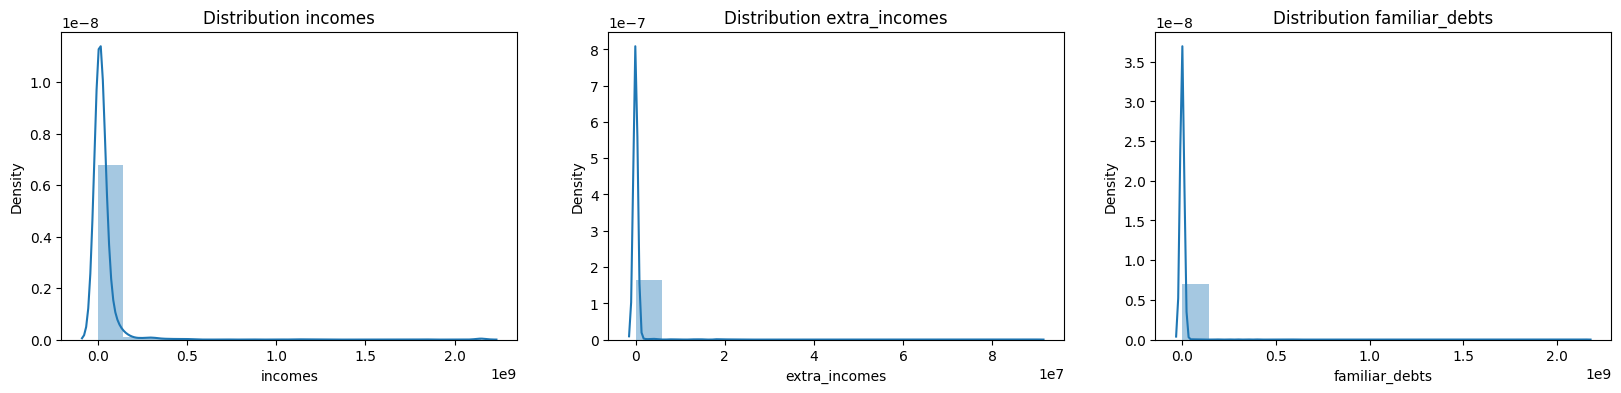

In [18]:
f, ax = plt.subplots(ncols=3, figsize=(20,4))

sns.distplot(habi_df['incomes'],bins=15, ax=ax[0])
ax[0].set_title('Distribution incomes')
skew= habi_df['incomes'].skew()
print('Ingresos iguales a cero = ',(habi_df['incomes']==0).sum()/len(habi_df),f'skew = {skew}')

sns.distplot(habi_df['extra_incomes'],bins=15, ax=ax[1])
skew= habi_df['extra_incomes'].skew()
ax[1].set_title('Distribution extra_incomes')
print('Ingresos Extra iguales a cero = ',(habi_df['extra_incomes']==0).sum()/len(habi_df),f'skew = {skew}')

sns.distplot(habi_df['familiar_debts'],bins=15, ax=ax[2])
skew= habi_df['familiar_debts'].skew()
x =ax[2].set_title('Distribution familiar_debts')
print('Deudas Familiares iguales a cero = ',(habi_df['familiar_debts']==0).sum()/len(habi_df),f'skew = {skew}')


In [19]:
habi_df['has_extra_incomes'] = (habi_df.extra_incomes==0).astype(int)
habi_df['has_familiar_debts'] = (habi_df.familiar_debts==0).astype(int)

Ingresos iguales a cero =  15 skew = 37.8809239292019
Ingresos Extra iguales a cero =  2189 skew = 37.8809239292019
Deudas Familiares iguales a cero =  1099 skew = 37.8809239292019


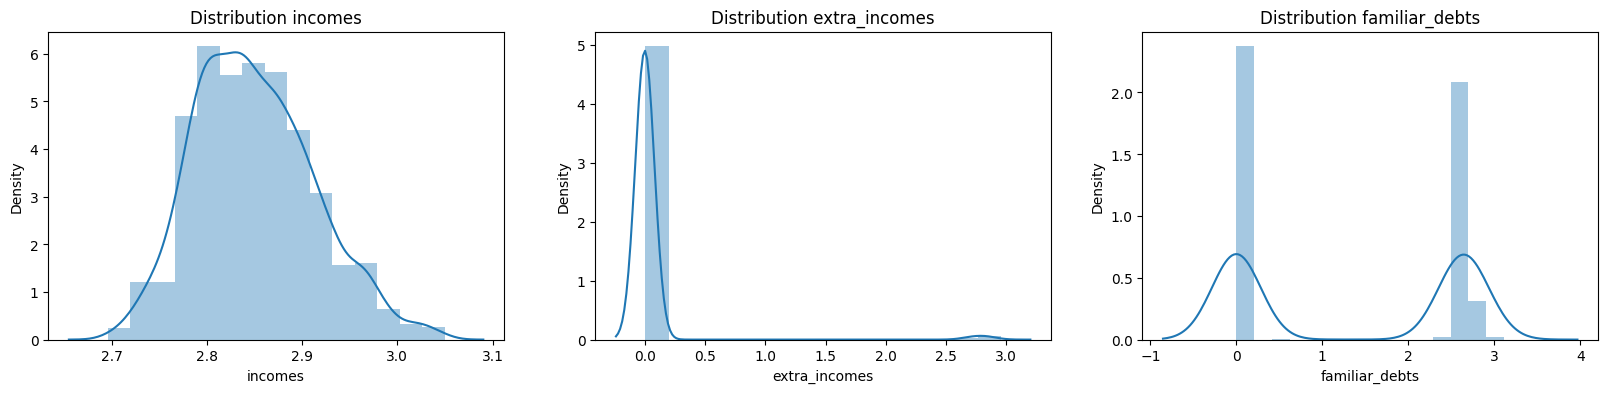

In [20]:
outliners_df = habi_df.copy()
outliners_df['incomes'] = np.log1p(outliners_df['incomes'])
outliners_df['extra_incomes'] = np.log1p(outliners_df['extra_incomes'])
outliners_df['familiar_debts'] = np.log1p(outliners_df['familiar_debts'])

q25, q75 = outliners_df['incomes'].quantile(0.25),outliners_df['incomes'].quantile(0.75)
iqr = q75 - q25
cut_off = iqr * 2
lower, upper = q25 - cut_off, q75 + cut_off
outliners_df = outliners_df[(outliners_df['incomes']>lower)&(outliners_df['incomes']<upper)]   

q25, q75 = outliners_df['familiar_debts'].quantile(0.25),outliners_df['familiar_debts'].quantile(0.75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
outliners_df = outliners_df[(outliners_df['familiar_debts']>lower)&(outliners_df['familiar_debts']<upper)] 

f, ax = plt.subplots(ncols=3, figsize=(20,4))

sns.distplot(np.log1p(outliners_df['incomes']),bins=15, ax=ax[0])
ax[0].set_title('Distribution incomes')
print('Ingresos iguales a cero = ',(habi_df['incomes']==0).sum(),f'skew = {skew}')

sns.distplot(np.log1p(outliners_df['extra_incomes']),bins=15, ax=ax[1])
ax[1].set_title('Distribution extra_incomes')
print('Ingresos Extra iguales a cero = ',(habi_df['extra_incomes']==0).sum(),f'skew = {skew}')

sns.distplot(np.log1p(outliners_df['familiar_debts']),bins=15, ax=ax[2])
x =ax[2].set_title('Distribution familiar_debts')
print('Deudas Familiares iguales a cero = ',(habi_df['familiar_debts']==0).sum(),f'skew = {skew}')



In [21]:
print('Eliminando los outliers conservamos el',len(outliners_df)/len(habi_df), 'del dataset')

Eliminando los outliers conservamos el 0.9851951547779273 del dataset


In [23]:
habi_df = outliners_df.copy()

Text(0.5, 1.0, 'Distribution extra_incomes')

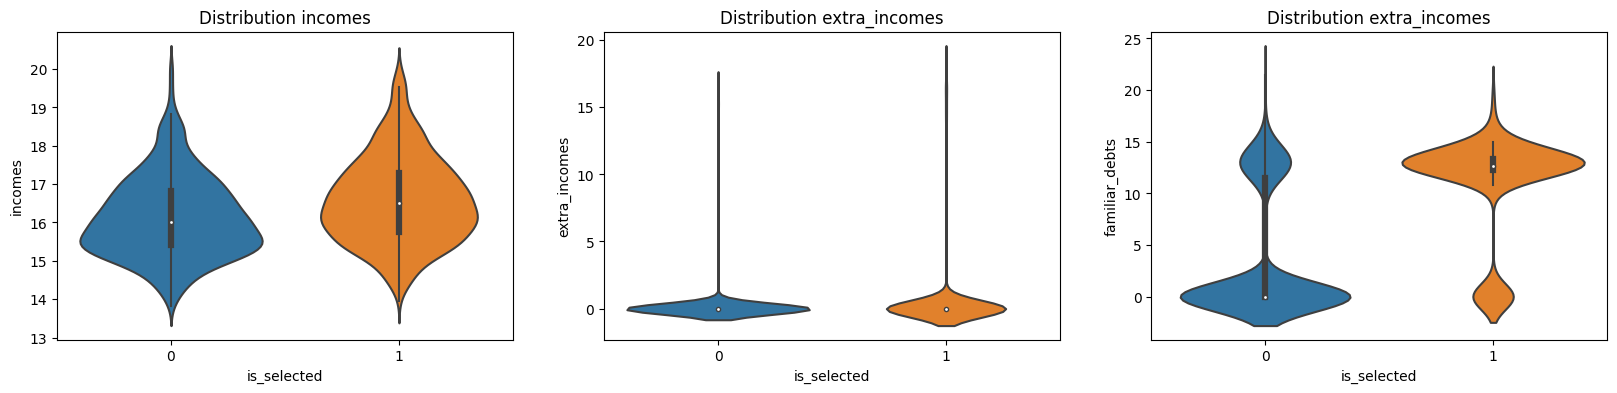

In [24]:
f, ax = plt.subplots(ncols=3, figsize=(20,4))

sns.violinplot(data=habi_df,x='is_selected',y='incomes',ax=ax[0])
ax[0].set_title('Distribution incomes')

sns.violinplot(data=habi_df,x='is_selected',y='extra_incomes', ax=ax[1])
ax[1].set_title('Distribution extra_incomes')

sns.violinplot(data=habi_df,x='is_selected',y='familiar_debts', ax=ax[2])
ax[2].set_title('Distribution extra_incomes')


In [25]:
habi_df['age'] = habi_df['year_birth'].max() -habi_df['year_birth']

In [26]:
def age_section(age):
    if age < 20:
        return 'less 20'
    elif age < 40:
        return 'less 40'
    else:
        return 'more 40'
habi_df['age_section'] = habi_df['age'].apply(age_section)

In [27]:
# Get the frequency counts of each name
name_counts = habi_df['region_id'].value_counts()
# Identify the names with frequency less than 15
unfrequent_names = name_counts[name_counts < 15].index
# Replace the unfrequent names with -1
habi_df['region_id'] = habi_df['region_id'].replace(unfrequent_names, -1).astype(str)

In [147]:
habi_df.to_parquet('./data/prepared/habi_feature.parquet',index=None)

In [28]:
habi_df = pd.read_parquet('./data/prepared/habi_feature.parquet')
habi_df['year_exp_token'] = habi_df['year_exp_token'].astype(str)

## 4. Modeling

### Oversampling

Nuestro dataset es imbalanceado, para la ello vamos a aplicar oversampling

In [33]:
habi_df = habi_df.sample(frac=1,random_state=5).reset_index(drop=True)

viability_df = habi_df.loc[habi_df['is_selected'] == 1]
non_viability_df = habi_df.loc[habi_df['is_selected'] == 0][:897]

normal_distributed_df = pd.concat([viability_df, non_viability_df])

# Shuffle dataframe 
habi_df = normal_distributed_df.sample(frac=1, random_state=42)

habi_df.shape

(1794, 23)

### Distribucion variable objetivo vs variables categoricas

In [37]:
binary_cols = ['terms_conditions','is_tax_return','viability','has_region_id','has_date_exp_token']
ohe_cols = ['type_independent_activity_id','region_id','activity','job_role','year_exp_token','year_birth','age_section','month_exp_token']
numerical_cols = ['incomes','extra_incomes','familiar_debts',] #'age'
categorical = binary_cols+ ohe_cols
target ='is_selected'


terms_conditions


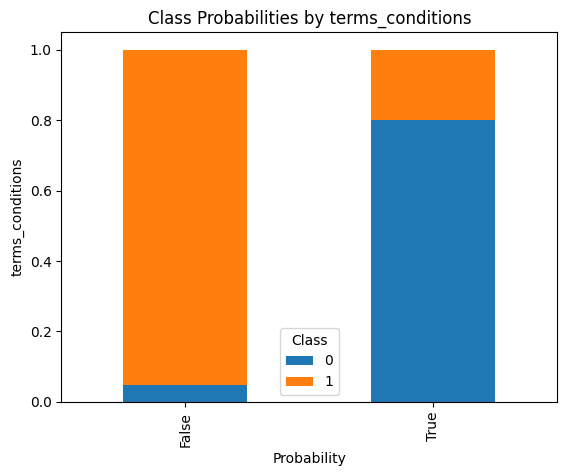

is_tax_return


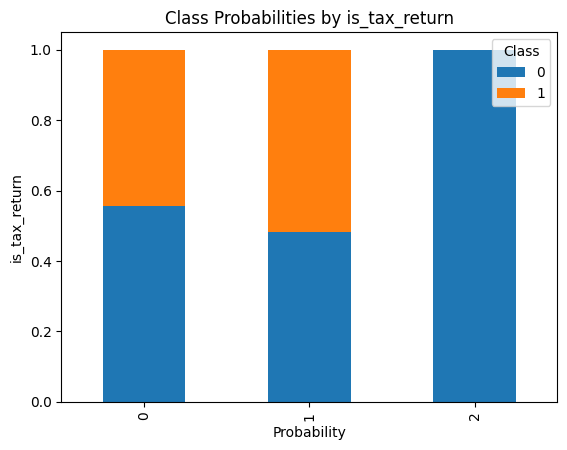

viability


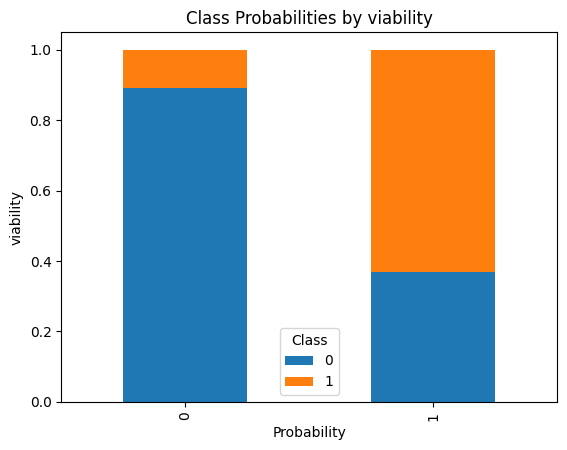

has_region_id


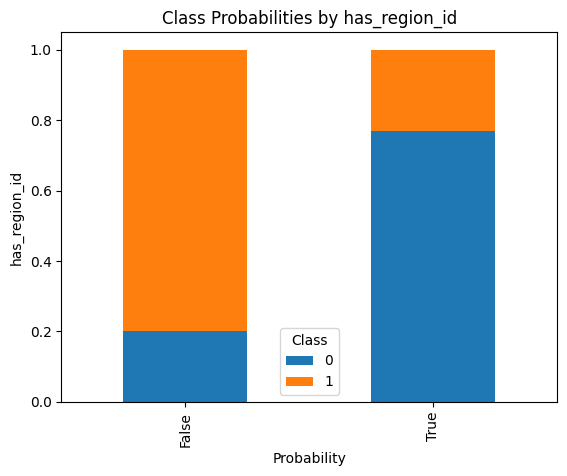

has_date_exp_token


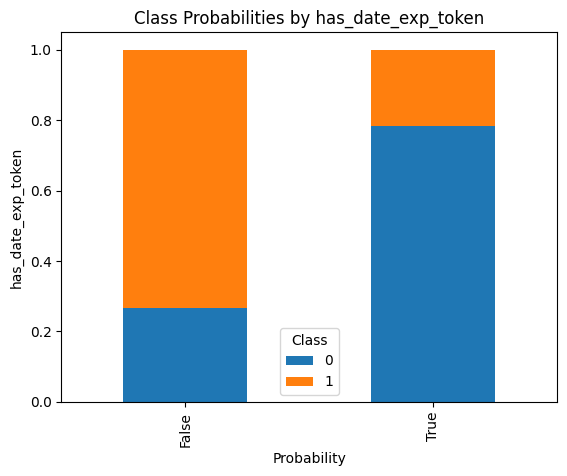

type_independent_activity_id


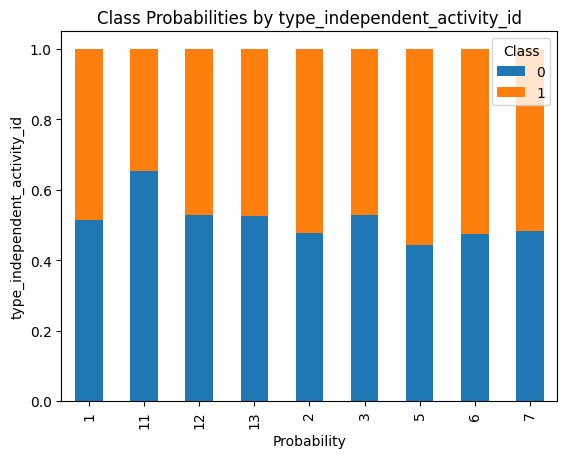

region_id


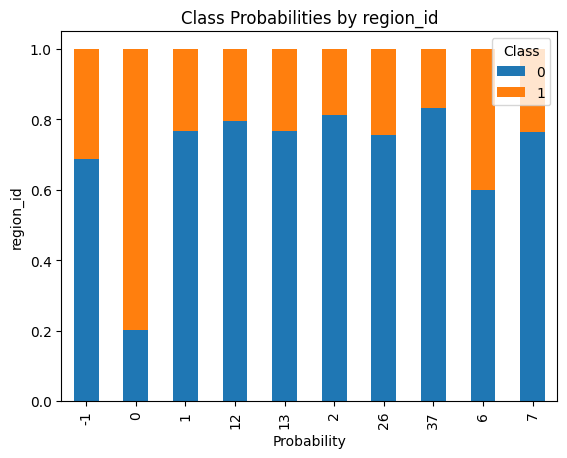

activity


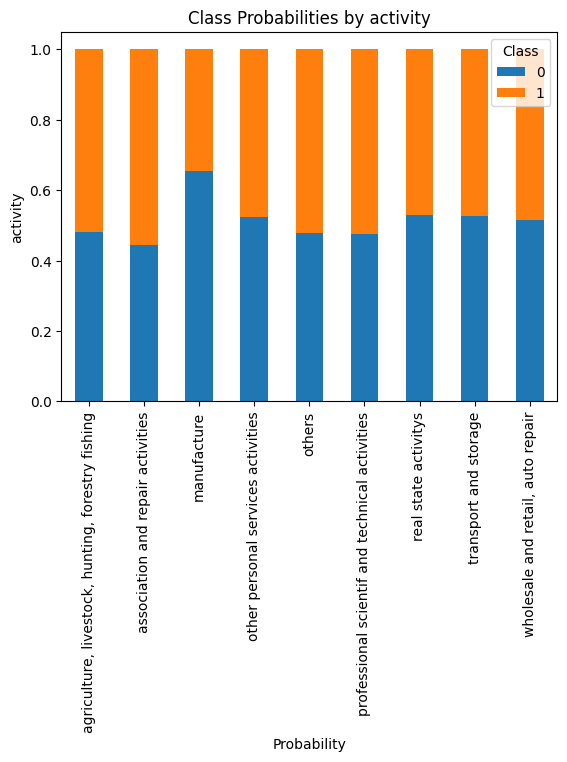

job_role


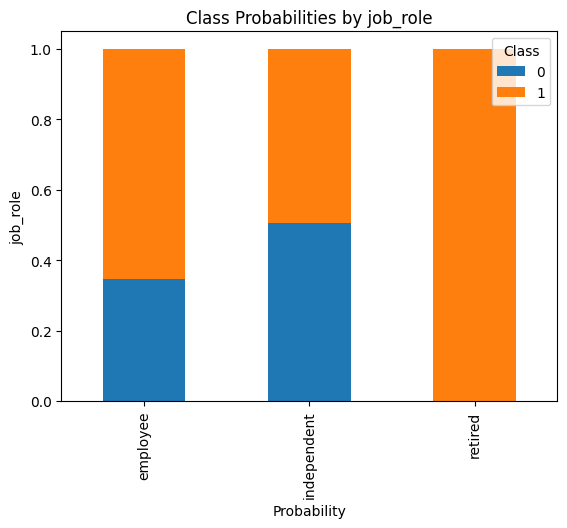

year_exp_token


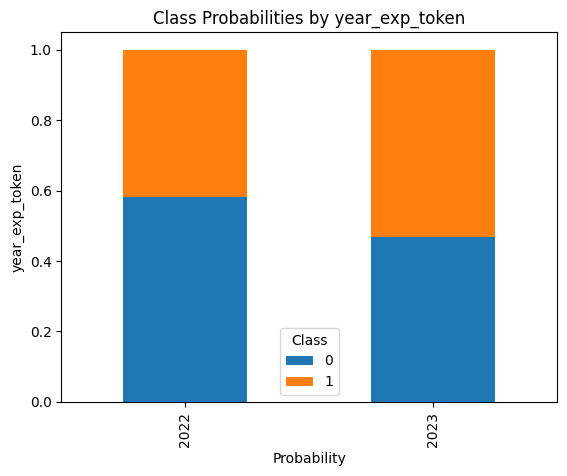

year_birth


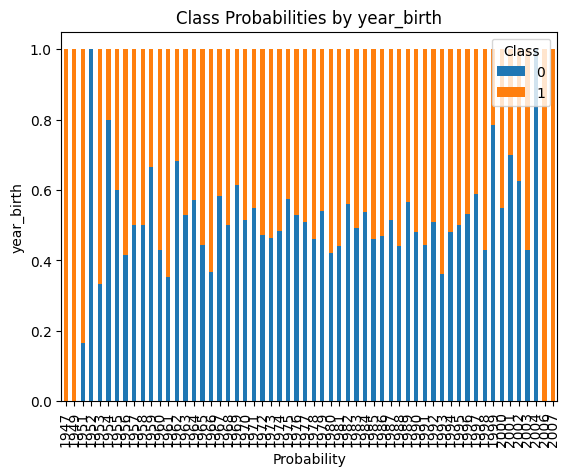

age_section


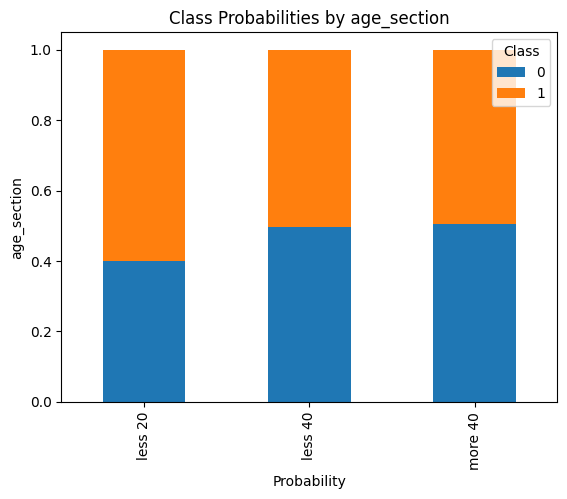

month_exp_token


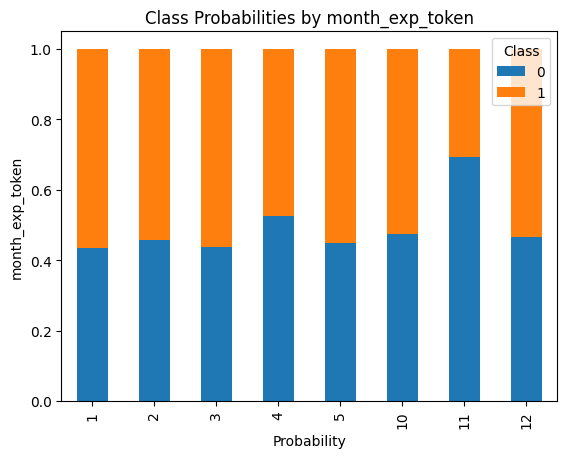

In [38]:
def proba_plot(df:pd.DataFrame,feature:str):
    # Calculate probabilities
    class_counts = df.groupby([feature, target]).size().unstack()
    class_probs = class_counts.div(class_counts.sum(axis=1), axis=0)

    # Plotting
    class_probs.plot(kind='bar', stacked=True)
    plt.xlabel('Probability')
    plt.ylabel(feature)
    plt.title(f'Class Probabilities by {feature}')
    plt.legend(title='Class')
    plt.show()
    

for c in categorical:
    print(c)
    proba_plot(habi_df,c)

# Feature importance

In [39]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series,habi_df['is_selected'])


mi = habi_df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

terms_conditions                0.316854
region_id                       0.172348
has_region_id                   0.170821
has_date_exp_token              0.138989
viability                       0.114513
month_exp_token                 0.014344
year_birth                      0.013634
year_exp_token                  0.005189
type_independent_activity_id    0.002541
activity                        0.002541
is_tax_return                   0.002406
job_role                        0.001827
age_section                     0.000136
dtype: float64

### One-Hot-Encoding

In [44]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer



ohe_cols = ['type_independent_activity_id','is_tax_return','region_id','activity','job_role','year_exp_token','age_section']
binary_cols = ['terms_conditions','viability','has_extra_incomes', 'has_familiar_debts', 'has_region_id', 'has_date_exp_token']
numerical_cols = ['incomes','extra_incomes','familiar_debts']

all_cols = ohe_cols+binary_cols+numerical_cols

X, y = habi_df[all_cols].reset_index(drop=True), habi_df['is_selected'].reset_index(drop=True)


data_dict = X.to_dict(orient='records')

# Create an instance of DictVectorizer and fit-transform the data
vectorizer = DictVectorizer(sparse=False)
encoded_features = vectorizer.fit_transform(data_dict)

dump_pickle(vectorizer,'./artifacts/dict_vectorizer.pkl')

X_encoded_df = pd.DataFrame(encoded_features, columns=vectorizer.get_feature_names_out())


In [45]:
X.to_dict(orient='records')[0]

{'type_independent_activity_id': '6',
 'is_tax_return': 1,
 'region_id': '0',
 'activity': 'professional scientif and technical activities',
 'job_role': 'independent',
 'year_exp_token': '2023',
 'age_section': 'less 40',
 'terms_conditions': True,
 'viability': 1,
 'has_extra_incomes': 1,
 'has_familiar_debts': 1,
 'has_region_id': False,
 'has_date_exp_token': False,
 'incomes': 16.52356082573315,
 'extra_incomes': 0.0,
 'familiar_debts': 0.0}

In [46]:
X.columns

Index(['type_independent_activity_id', 'is_tax_return', 'region_id',
       'activity', 'job_role', 'year_exp_token', 'age_section',
       'terms_conditions', 'viability', 'has_extra_incomes',
       'has_familiar_debts', 'has_region_id', 'has_date_exp_token', 'incomes',
       'extra_incomes', 'familiar_debts'],
      dtype='object')

In [156]:
#encoded_df.to_csv('./data/prepared/habi_train.csv',index=None)

In [157]:
#encoded_df = pd.read_csv('./data/prepared/habi_train.csv')

# Train

In [47]:
from sklearn.model_selection import train_test_split,StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y,test_size=0.2, random_state=6, stratify=y)


In [48]:
from sklearn.metrics import f1_score
import optuna
from sklearn.metrics import confusion_matrix, classification_report

class ModelTrainer:
    def __init__(self, search_space, model, n_trials=10, n_jobs=8, cv=2):
        self.search_space = search_space
        self.model = model
        self.n_trials = n_trials
        self.n_jobs = n_jobs
        self.cv = cv
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.best_model = None
        
    def fit_data(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def evaluate_model(self, trial, x_train, y_train, x_val, y_val):
        params = self.search_space(trial)
    
        # Create the classifier
        classifier = self.model(**params)
        
        # Fit the classifier
        classifier.fit(x_train, y_train)
        
        # Make predictions
        preds = classifier.predict(x_val)
        
        # Calculate evaluation metrics
        score = f1_score(y_val, preds, average='weighted')
        
        return score
    
    def evaluate_cv(self, trial):        
        skf = StratifiedKFold(n_splits=self.cv)
        score_list = []
        
        for train_index, test_index in skf.split(self.X_train, self.y_train):
            x_train_fold, x_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_fold, y_val_fold = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
            score = self.evaluate_model(trial, x_train_fold, y_train_fold, x_val_fold, y_val_fold)
            score_list.append(score)
        
        return np.mean(score_list)
    
    def optimize_model(self):
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')

        # Optimize the objective function
        study.optimize(self.evaluate_cv, n_trials=self.n_trials, n_jobs=self.n_jobs)
        best_params = study.best_params
        best_score = study.best_value

        self.best_classifier = self.model(**best_params)
        self.best_classifier.fit(self.X_train, self.y_train)
        
        return best_params, best_score,self.best_classifier
    
    
class MetricPlots():
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = self.model.predict(self.X_test)
        self.labels = np.unique(self.y_test)
        
    def confusion_matrix(self):
        labels = [0,1]
        cm = confusion_matrix(self.y_test, self.y_pred,labels=labels)
        cm_df = pd.DataFrame(cm ,columns=labels,index=labels)
        plt.figure(figsize=(8, 8))
        plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
        plot.set(xlabel='Predicted', ylabel='Actual')
        
    def classification_report(self):
        print(classification_report(self.y_test, self.y_pred, labels=self.labels))

        


In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

def SearchSpace():    
    def XGBClassifier(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'booster': 'gbtree',
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
        }    
        return params
    
    def LogisticRegression(trial):
        params = {
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'C': trial.suggest_loguniform('C', 0.001, 100.0),
            'solver': trial.suggest_categorical('solver', [ 'liblinear', 'saga']),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
            'max_iter': trial.suggest_int('max_iter', 100, 10000),
            'random_state': 42
        }
        return params
    
    def SVC(trial):
        params = {
            'C': trial.suggest_loguniform('C', 0.001, 100.0),
            'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
            'degree': trial.suggest_int('degree', 1, 5),
            'random_state': 42,
            'probability':trial.suggest_categorical('probability', [True])
        }
        return params
    
    def MLPClassifier(trial):
        hidden_layer_sizes_choices = [
            (10,),
            (20,),
            (30,),
            (40,),
            (10, 10),
            (20, 20),
            (40, 40),
            (10, 20),
            (10,10,10)
        ]   
        
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes',  hidden_layer_sizes_choices),
            'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
            #'learning_rate': trial.suggest_categorical('learning_rate', ['invscaling', 'adaptive']),
            'alpha':trial.suggest_loguniform('alpha', 1e-5, 1e-1),
            'random_state': 42
        }
        
        return params
    
    return dict(XGBClassifier=XGBClassifier,
                LogisticRegression=LogisticRegression,
                SVC=SVC,
                MLPClassifier=MLPClassifier)




In [50]:
# Test
model_params = SearchSpace()
# Model list for hyperparameter tuning
cv_models = [
    (xgb.XGBClassifier,model_params['XGBClassifier'],'XGBClassifier'),
    (LogisticRegression,model_params['LogisticRegression'],'LogisticRegression'),
    (SVC,model_params['SVC'],'SVC'),
    (MLPClassifier,model_params['MLPClassifier'],'MLPClassifier')
]

best_models = {}

for model, params, name in cv_models:
    model_trainer= ModelTrainer(params,model,n_trials=5,cv=3,n_jobs=-1)    
    model_trainer.fit_data(X_train,y_train,X_test,y_test)    
    best_params, best_score, best_model = model_trainer.optimize_model()
    best_models[name] = best_model
    print(f'----------MODEL: {name} ----------')
    print(f'Best score {best_score:.4f}' )
    print(f'params =  {best_params}' )
    print(f'CLASSIFICATION METRICS')
    print(f'')
    mp = MetricPlots(best_model,X_test,y_test)
    mp.classification_report()
    print(f'\n')
    



----------MODEL: XGBClassifier ----------
Best score 0.8700
params =  {'max_depth': 9, 'learning_rate': 0.0725289874805177, 'subsample': 0.7, 'colsample_bytree': 0.9, 'n_estimators': 701, 'gamma': 0.45897084131244115, 'reg_alpha': 8.448783272797499, 'reg_lambda': 3.184409448573623}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       180
           1       0.92      0.80      0.85       179

    accuracy                           0.86       359
   macro avg       0.87      0.86      0.86       359
weighted avg       0.87      0.86      0.86       359



----------MODEL: LogisticRegression ----------
Best score 0.8517
params =  {'penalty': 'l1', 'C': 0.06882213783907515, 'solver': 'liblinear', 'fit_intercept': False, 'max_iter': 7268}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       180
           1       0.89      0.80      0.84    

In [287]:

model_params = SearchSpace()
# Model list for hyperparameter tuning
cv_models = [
    (xgb.XGBClassifier,model_params['XGBClassifier'],'XGBClassifier'),
    (LogisticRegression,model_params['LogisticRegression'],'LogisticRegression'),
    (SVC,model_params['SVC'],'SVC'),
    (MLPClassifier,model_params['MLPClassifier'],'MLPClassifier')
]

best_models = {}

for model, params, name in cv_models:
    model_trainer= ModelTrainer(params,model,n_trials=40,cv=5,n_jobs=-1)    
    model_trainer.fit_data(X_train,y_train,X_test,y_test)    
    best_params, best_score, best_model = model_trainer.optimize_model()
    best_models[name] = best_model
    print(f'----------MODEL: {name} ----------')
    print(f'Best score {best_score:.4f}' )
    print(f'params =  {best_params}' )
    print(f'CLASSIFICATION METRICS')
    print(f'')
    mp = MetricPlots(best_model,X_test,y_test)
    mp.classification_report()
    print(f'\n')
    



----------MODEL: XGBClassifier ----------
Best score 0.7612
params =  {'max_depth': 8, 'learning_rate': 0.01074360154089265, 'subsample': 0.9, 'colsample_bytree': 0.6, 'n_estimators': 950, 'gamma': 0.256994353368153, 'reg_alpha': 7.792864303315782, 'reg_lambda': 5.9388443958171155}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       129
           1       0.85      0.74      0.79       129

    accuracy                           0.81       258
   macro avg       0.81      0.81      0.81       258
weighted avg       0.81      0.81      0.81       258



----------MODEL: LogisticRegression ----------
Best score 0.7581
params =  {'penalty': 'l1', 'C': 1.4015129648294156, 'solver': 'saga', 'fit_intercept': False, 'max_iter': 5480}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       129
           1       0.85      0.77      0.80       129

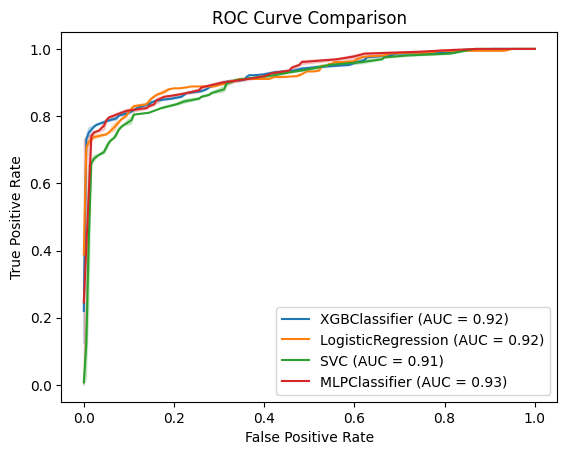

In [51]:
import seaborn as sns
from sklearn import metrics

# Create an empty figure and axis object
fig, ax = plt.subplots()

# Iterate over the models
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.auc(fpr, tpr)
    sns.lineplot(x=fpr,y= tpr, ax=ax, label=f'{name} (AUC = {auc:.2f})')

# Set labels for the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison')

# Display the plot
plt.show()

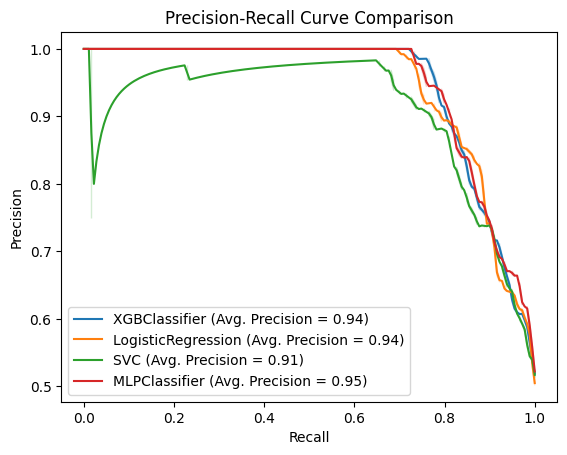

In [52]:
import seaborn as sns
from sklearn import metrics

# Create an empty figure and axis object
fig, ax = plt.subplots()

# Iterate over the models
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    average_precision = metrics.average_precision_score(y_test, y_pred_proba)
    sns.lineplot(x=recall, y=precision, ax=ax, label=f'{name} (Avg. Precision = {average_precision:.2f})')

# Set labels for the plot
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve Comparison')
ax.legend()

# Display the plot
plt.show()

## Export models

In [102]:

for name, model in best_models.items():
    print('Saving = ',name)
    dump_pickle(model,f'./models/{name}.pkl')
    

Saving =  XGBClassifier
Saving =  LogisticRegression
Saving =  SVC
Saving =  MLPClassifier


# Feature importance 

In [177]:
# Get feature importances
'''importances = best_classifier.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

feature_importances.head(10)'''

"importances = best_classifier.feature_importances_\n\n# Create a DataFrame with feature names and importances\nfeature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})\n\n# Sort the features by importance in descending order\nfeature_importances = feature_importances.sort_values('Importance', ascending=False)\n\nfeature_importances.head(10)"

In [178]:
#top_features = feature_importances[feature_importances['Importance']>0.013]['Feature'].to_list()
#top_features

In [306]:


data = [
    {'has_extra_incomes': 0, 'age': 30, 'region': 'A'},
    {'has_extra_incomes': 1, 'age': 35, 'region': 'B'},
    {'has_extra_incomes': 0, 'age': 40, 'region': 'C'}
]

df = pd.DataFrame(data)

# Convert features to a dictionary representation
data_dict = df.to_dict(orient='records')

# Create an instance of DictVectorizer and fit-transform the data
vectorizer = DictVectorizer(sparse=False)
encoded_features = vectorizer.fit_transform(data_dict)

# Create a DataFrame for the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=vectorizer.get_feature_names_out())

print(encoded_df)

    age  has_extra_incomes  region=A  region=B  region=C
0  30.0                0.0       1.0       0.0       0.0
1  35.0                1.0       0.0       1.0       0.0
2  40.0                0.0       0.0       0.0       1.0
